# Práctica 1 (Desarrollo de Software Crítico)
Autor: Juan Carlos Alcausa Luque

## 1. Construcción del modelo LSTM y detección de anomalías

### a) Construcción de modelo básico LSTM

Un LSTM (Long Short-Term Memory, “memoria a largo plazo”) es un tipo de celda de red neuronal recurrente (RNN) diseñada para aprender dependencias temporales largas en secuencias, resolviendo en gran parte el problema del desvanecimiento/explosión del gradiente que afecta a las RNN simples. Aquí seguiremos el ejemplo de modelo proporcionado y comenzaremos trabajando con éste. Más adelante veremos cómo podemos mejorarlo

#### Profundizando en LSTM

Como se mencionó, LSTM (Long Short-Term Memory) es una arquitectura avanzada dentro de las Redes Neuronales Recurrentes (RNNs). Su diseño específico aborda una limitación clave de las RNNs simples: el problema del "desvanecimiento del gradiente" (vanishing gradient) y, en menor medida, el de "explosión del gradiente" (exploding gradient).

* **Desvanecimiento del Gradiente:** En RNNs profundas o al procesar secuencias largas, los gradientes (usados para actualizar los pesos de la red durante el entrenamiento) pueden volverse extremadamente pequeños a medida que retroceden en el tiempo. Esto impide que los pesos de las capas iniciales se actualicen correctamente, dificultando el aprendizaje de dependencias a largo plazo.
* **Explosión del Gradiente:** Es el problema opuesto, donde los gradientes se vuelven extremadamente grandes, llevando a actualizaciones de pesos inestables y divergencia en el entrenamiento.

Las LSTMs mitigan esto mediante una estructura de celda más compleja que incluye:

1.  **Estado de Celda (Cell State):** Actúa como una "cinta transportadora" de información a través del tiempo, permitiendo que la información relevante persista sin degradarse significativamente.
2.  **Compuertas (Gates):** Son mecanismos (compuerta de olvido, compuerta de entrada, compuerta de salida) que regulan el flujo de información hacia y desde el estado de celda. Aprenden qué información es importante mantener, cuál olvidar y cuál añadir o emitir.

Esto permite a las LSTMs recordar información durante períodos más largos, haciéndolas ideales para tareas con series temporales como la nuestra, donde el valor actual puede depender de valores observados mucho antes. En este caso, la utilizaremos para predecir el siguiente valor de temperatura basándonos en una secuencia de valores anteriores.

Comenzamos importando las librerías que utilizaremos:

#### Importación de Librerías Necesarias

Antes de comenzar, importaremos las bibliotecas de Python que nos proporcionarán las herramientas necesarias para la manipulación de datos, el cálculo numérico, la visualización y la construcción del modelo de aprendizaje profundo.

* `numpy` (con el alias `np`): Fundamental para operaciones numéricas, especialmente con arrays multidimensionales.
* `pandas` (con el alias `pd`): Esencial para la manipulación y análisis de datos, sobre todo con estructuras como los DataFrames.
* `matplotlib.pyplot` (con el alias `plt`): Utilizada para crear visualizaciones estáticas, como gráficos de líneas.
* `tensorflow` (con el alias `tf`) y `keras`: `tensorflow` es la biblioteca subyacente para el cómputo numérico y el aprendizaje automático. `keras` es una API de alto nivel (integrada en TensorFlow) que facilita la definición, entrenamiento y evaluación de modelos de redes neuronales, incluyendo LSTMs. Importamos `Sequential` para construir el modelo capa por capa, y `LSTM`, `Dense` e `Input` para definir las capas específicas.
* `joblib`: se usa guardar y cargar modelos entrenados o pipelines de preprocesamiento.

In [6]:
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense, Input
from sklearn.model_selection import train_test_split
import joblib

Ahora necesitamos cargar los datos con los que vamos a trabajar (los de datos.csv)

In [7]:
df = pd.read_csv("datos.csv",index_col=0,parse_dates=True)

#### Carga y Exploración Inicial de Datos

Hemos cargado los datos desde el archivo "datos.csv" en un DataFrame de pandas llamado `df`.

* `index_col=0`: Indica que la primera columna del CSV debe usarse como el índice del DataFrame. En datos de series temporales, esta suele ser la columna de fecha/hora.
* `parse_dates=True`: Intenta convertir automáticamente la columna de índice (o cualquier columna especificada si `index_col` no fuera 0) a objetos de tipo fecha/hora (datetime).

A continuación, visualizaremos el tamaño de los datos (número de filas y columnas) y trazaremos la serie temporal para tener una idea inicial de su comportamiento, tendencias, estacionalidad y posibles valores anómalos.

(7267, 1)


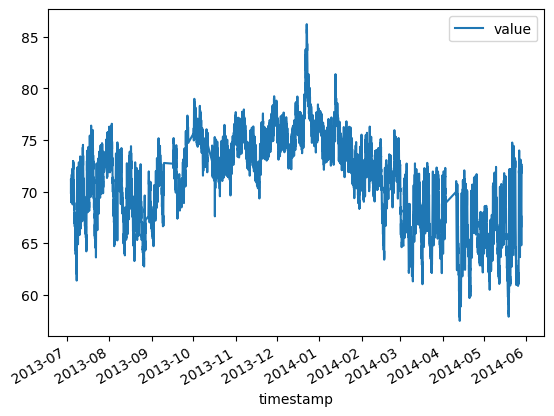

In [8]:
print(df.shape)
df.plot()
plt.show()

#### Preparación de Datos: Creación de Ventanas Temporales

Los modelos LSTM, al igual que otras RNNs, no procesan los datos punto por punto de forma aislada. Necesitan secuencias de entrada para aprender patrones temporales. Por lo tanto, debemos transformar nuestra serie temporal lineal en un conjunto de "ventanas" deslizantes.

Cada ventana consistirá en una secuencia de `n_steps` observaciones consecutivas (las características de entrada, `X`) y el valor inmediatamente posterior a esa secuencia (la etiqueta o valor objetivo que queremos predecir, `y`).

La función `split_sequence` implementará esta lógica de ventana deslizante. Iterará sobre la secuencia original y, para cada posición `i`, tomará los siguientes `n_steps` puntos como entrada (`seq_x`) y el punto `n_steps+1` como salida (`seq_y`).

In [9]:
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

In [10]:
n_steps = 10

# Extraemos los datos del dataframe correspondientes a la temperatura y convertimos a ndarray
# df.iloc[:, 0] significa “todas las filas (:) y la columna en posición 0 (que es temperature porque la primera se usa como índice”
temperatures = df.iloc[:, 0].to_numpy()


# Crear ventanas
X, y = split_sequence(temperatures, n_steps)

#### Estructura de los Datos Transformados en ventanas

Después de aplicar `split_sequence` con `n_steps = 10`, hemos transformado la serie original `temperatures` en dos arrays NumPy:

* `X`: Un array donde cada fila contiene una secuencia de 10 valores consecutivos de temperatura. Si la serie original tenía `N` puntos, `X` tendrá `N - n_steps` filas y `n_steps` (10) columnas.
* `y`: Un array que contiene el valor de temperatura que sigue inmediatamente a cada secuencia en `X`. Tendrá `N - n_steps` elementos.

Por ejemplo, `X[0]` contendrá `temperatures[0:10]` y `y[0]` contendrá `temperatures[10]`. Luego, `X[1]` contendrá `temperatures[1:11]` y `y[1]` contendrá `temperatures[11]`, y así sucesivamente.

In [11]:
# reshape from [samples, timesteps] into [samples, , features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))

# Para detección de anomalías, entrenamos con todos los datos
# ya que asumimos que la mayoría son valores normales
print(f"Tamaño de X: {X.shape}")
print(f"Tamaño de y: {y.shape}")

Tamaño de X: (7257, 10, 1)
Tamaño de y: (7257,)


#### Adecuación de la Forma de Entrada para LSTM (Reshape)

Las capas LSTM en TensorFlow esperan que los datos de entrada tengan una forma tridimensional específica: `[samples, timesteps, features]`.

* `samples`: El número de ventanas o secuencias que hemos creado (equivalente al número de filas en nuestro `X` antes del reshape, `X.shape[0]`).
* `timesteps`: La longitud de cada secuencia de entrada (nuestro `n_steps`, `X.shape[1]`).
* `features`: El número de variables que observamos en cada paso temporal. En nuestro caso, solo estamos usando la temperatura, por lo que `n_features = 1`. Si tuviéramos más variables (ej., humedad, presión), este número sería mayor.

El comando `X.reshape((X.shape[0], X.shape[1], n_features))` ajusta nuestro array `X` (que originalmente era 2D: `[samples, timesteps]`) a esta forma 3D requerida por la capa LSTM.

**Importante para detección de anomalías**: A diferencia de tareas de predicción supervisada tradicionales, aquí NO dividimos los datos en entrenamiento y prueba con shuffle, ya que:
1. Las series temporales requieren mantener el orden cronológico
2. Para detección de anomalías no supervisada, entrenamos con todos los datos asumiendo que la mayoría son valores normales

#### Definición del Modelo LSTM Básico

Ahora construiremos nuestro primer modelo LSTM utilizando la API `Sequential` de Keras. Este modelo será relativamente simple, con una única capa LSTM seguida de una capa densa para la salida.

* `Sequential()`: Crea un contenedor lineal de capas. Añadiremos capas una tras otra.
* `Input(shape=(n_steps, n_features))`: Define la forma esperada de cada muestra de entrada, excluyendo la dimensión del batch. Es crucial que coincida con la forma que preparamos anteriormente.
* `LSTM(50, activation='relu')`: Esta es la capa recurrente principal.
    * `50`: Es el número de unidades (o neuronas) en la capa LSTM. Este es un hiperparámetro que define la capacidad de la capa para aprender patrones. Un número mayor permite aprender patrones más complejos pero aumenta el riesgo de sobreajuste y el coste computacional.
    * `activation='relu'`: Especifica la función de activación a usar en las transformaciones internas de la celda LSTM. Aquí se usa `relu` (Rectified Linear Unit). ReLU puede ayudar a mitigar el desvanecimiento del gradiente en redes profundas.
* `Dense(1)`: Es una capa de salida totalmente conectada (fully connected).
    * `1`: Indica que la capa tendrá una única neurona de salida, lo cual es apropiado porque estamos prediciendo un único valor (la siguiente temperatura). La activación por defecto para `Dense` es lineal, adecuada para problemas de regresión como este.
* `model.compile(optimizer='adam', loss='mse')`: Configura el proceso de aprendizaje del modelo.
    * `optimizer='adam'`: Adam (Adaptive Moment Estimation) es un algoritmo de optimización que adapta la tasa de aprendizaje para cada parámetro. Suele funcionar bien en muchos problemas.
    * `loss='mse'`: Especifica la función de pérdida a minimizar durante el entrenamiento. MSE (Mean Squared Error, Error Cuadrático Medio) es una métrica estándar para problemas de regresión, que penaliza más los errores grandes.

In [12]:
# define model
model = Sequential()
model.add(Input(shape=(n_steps, n_features)))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

model.fit(X, y, epochs=200)

Epoch 1/200
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 75.8019 
Epoch 2/200
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 75.8019 
Epoch 2/200
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1351
Epoch 3/200
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1351
Epoch 3/200
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0585
Epoch 4/200
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0585
Epoch 4/200
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0673
Epoch 5/200
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0673
Epoch 5/200
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0434
Epoch 6/200
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0434
Epoch 6/200
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9901
Epoch 7/200
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9901
Epoch 7/200
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9728
Epoch 8/200
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9728
Epoch 8/200
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 

#### Entrenamiento del Modelo

El comando `model.fit(X, y, epochs=200)` inicia el proceso de entrenamiento.

* `X`: Todas las secuencias de temperatura. En detección de anomalías, entrenamos con todos los datos disponibles asumiendo que la mayoría son valores normales.
* `y`: Los valores objetivo correspondientes (la temperatura siguiente a cada secuencia).
* `epochs=200`: Una época es una pasada completa por todo el conjunto de datos de entrenamiento. Entrenar durante 200 épocas significa que el modelo verá y aprenderá de todos los datos 200 veces. Durante cada época, el optimizador ajusta los pesos del modelo para minimizar la función de pérdida (MSE en este caso). La salida muestra cómo la pérdida disminuye (idealmente) a lo largo de las épocas.

### b) Detección de anomalías

#### Detección de Anomalías Basada en el Error de Predicción

Una vez entrenado el modelo LSTM, podemos usarlo para detectar anomalías. La idea central es que el modelo ha aprendido el comportamiento "normal" de la serie temporal a partir de los datos de entrenamiento. Por lo tanto, cuando se le presente una secuencia normal, debería ser capaz de predecir el siguiente valor con un error relativamente bajo. Sin embargo, si ocurre un comportamiento anómalo, el modelo (entrenado en datos normales) probablemente tendrá dificultades para predecirlo, resultando en un error de predicción significativamente mayor.

Utilizaremos el Error Absoluto Medio (MAE) entre el valor real (`y_true`) y el valor predicho (`y_pred`) como métrica de error para cada ventana. El MAE es simplemente la diferencia absoluta entre la predicción y el valor real.

Luego, estableceremos un umbral estadístico. Una anomalía se marcará si el MAE para una ventana específica supera este umbral. Un método común (y el que usaremos aquí) es definir el umbral como un múltiplo (`k`) de la media de todos los MAE calculados sobre el conjunto de datos.

Umbral = 2.2934 (k=3.0), Anomalías detectadas = 71 sobre 7257


,date,y_true,y_pred,mae,anomaly
162,2013-07-11 04:00:00,66.495499,68.892426,2.396926,True
186,2013-07-12 04:00:00,67.431484,69.830330,2.398846,True
284,2013-07-16 06:00:00,67.990076,70.287712,2.297636,True
466,2013-07-23 20:00:00,71.042741,73.591087,2.548346,True
608,2013-07-31 02:00:00,72.998687,75.519241,2.520554,True
...,...,...,...,...,...
7122,2014-05-23 01:00:00,67.222749,69.652802,2.430053,True
7146,2014-05-24 01:00:00,67.447373,70.977814,3.530441,True
7151,2014-05-24 06:00:00,63.734240,66.130898,2.396657,True
7215,2014-05-26 22:00:00,69.023778,71.596291,2.572513,True


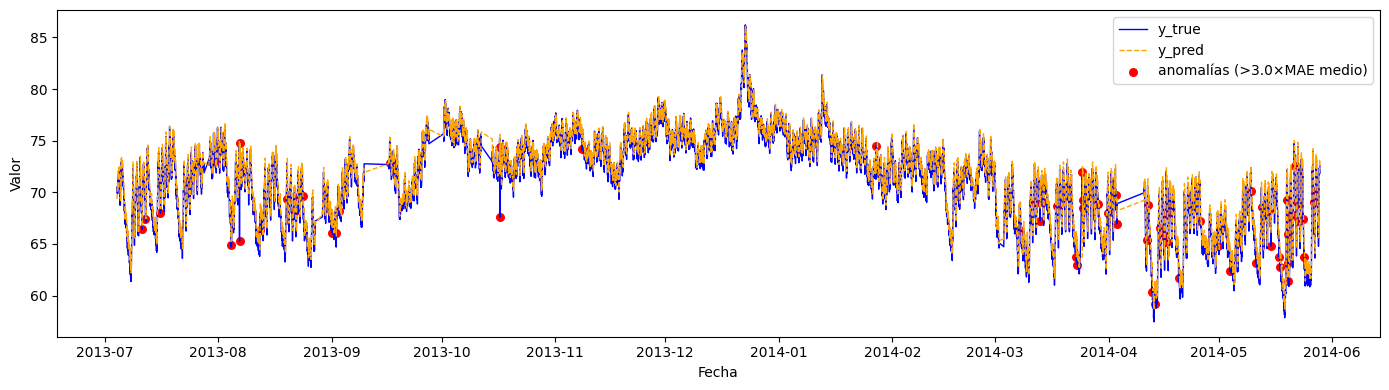

In [13]:
# 1) predecir
y_pred = model.predict(X, verbose=0).flatten()

# 2) MAE por ventana
mae = np.abs(y_pred - y)

# 3) umbral: k * mean(MAE)
k = 3.0
umbral = mae.mean() * k

# 4) flags de anomalía
anomalies = mae > umbral

# 5) mapear a fechas (y[i] corresponde a df.index[windows_size + i])
dates = df.index[n_steps : n_steps + len(y)]

# Crear DataFrame de resultados y mostrar resumen de anomalías
results = pd.DataFrame({
    'date': dates,
    'y_true': y,
    'y_pred': y_pred,
    'mae': mae,
    'anomaly': anomalies
})

print(f"Umbral = {umbral:.4f} (k={k}), Anomalías detectadas = {results['anomaly'].sum()} sobre {len(results)}")

# Mostrar tabla con las anomalías
if results['anomaly'].any():
    display(results[results['anomaly']])
else:
    print('No se detectaron anomalías con el umbral actual.')

# 6) plot sencillo: y_true (azul), y_pred (naranja --) y marcas rojas donde hay anomalía
plt.figure(figsize=(14,4))
plt.plot(dates, y, label='y_true', color='blue', linewidth=1)
plt.plot(dates, y_pred, label='y_pred', color='orange', linestyle='--', linewidth=1)
plt.scatter(dates[anomalies], y[anomalies], color='red', s=30, label=f'anomalías (>{k}×MAE medio)')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.tight_layout()
plt.show()

### c) Mejora del modelo

#### Mejora del Modelo: Aumentando Complejidad y Contexto

El modelo básico funcionó, pero podemos intentar mejorarlo para capturar potencialmente patrones más complejos o dependencias a más largo plazo. Realizaremos dos cambios principales:

1.  **Aumentar el Tamaño de la Ventana (`n_steps = 20`):** Al usar secuencias de entrada más largas (20 pasos temporales en lugar de 10), le damos al modelo más contexto histórico para realizar cada predicción. Esto podría ayudarle a aprender dependencias temporales más largas.
2.  **Añadir una Segunda Capa LSTM:** Apilar capas LSTM puede aumentar la capacidad del modelo para aprender representaciones más abstractas y complejas de los datos temporales. Para poder apilar LSTMs, es crucial que la primera capa LSTM (`LSTM(50, activation='relu', return_sequences=True)`) devuelva la secuencia completa de salidas para cada paso temporal (una salida por cada uno de los 20 timesteps), en lugar de solo la salida del último paso. Esto se logra estableciendo `return_sequences=True`. La segunda capa LSTM (`LSTM(50, activation='relu')`) ya no necesita devolver secuencias, ya que su salida irá directamente a la capa `Dense` final.

Volveremos a entrenar el modelo con esta nueva arquitectura y tamaño de ventana, y luego repetiremos el proceso de detección de anomalías para evaluar si estos cambios han mejorado el rendimiento.

In [14]:
n_steps = 20

# Extraemos los datos del dataframe correspondientes a la temperatura y convertimos a ndarray
# df.iloc[:, 0] significa “todas las filas (:) y la columna en posición 0 (que es temperature porque la primera se usa como índice”
temperatures = df.iloc[:, 0].to_numpy()


# Crear ventanas
X, y = split_sequence(temperatures, n_steps)

# reshape from [samples, timesteps] into [samples, , features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))

# Para detección de anomalías, entrenamos con todos los datos
print(f"Tamaño de X (mejorado): {X.shape}")
print(f"Tamaño de y (mejorado): {y.shape}")

# define model
model = Sequential()
model.add(Input(shape=(n_steps, n_features)))
model.add(LSTM(50, activation='relu', return_sequences=True))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# fit model - Entrenamos con todos los datos
model.fit(X, y, epochs=200)

Tamaño de X (mejorado): (7247, 20, 1)
Tamaño de y (mejorado): (7247,)
Epoch 1/200
227/227 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 443.3963 
Epoch 2/200
227/227 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 443.3963 
Epoch 2/200
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 52.6045
Epoch 3/200
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 52.6045
Epoch 3/200
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 264.3680
Epoch 4/200
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 264.3680
Epoch 4/200
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.6726
Epoch 5/200
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.6726
Epoch 5/200
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.1159
Epoch 6/200
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.1159
Epoch 6/200
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0989
Epoch 7/200
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0989
Epoch 7/200
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.0276
Epoch 8/200
227/227 ━━━━━━━━━━━━━━

Umbral = 55.8611 (k=3.0), Anomalías detectadas = 252 sobre 7247


,date,y_true,y_pred,mae,anomaly
99,2013-07-08 23:00:00,68.368368,-0.216393,68.584761,True
100,2013-07-09 00:00:00,68.421987,-11.423425,79.845412,True
101,2013-07-09 01:00:00,67.558244,-24.052332,91.610575,True
102,2013-07-09 02:00:00,66.488432,-12.712487,79.200919,True
103,2013-07-09 03:00:00,66.009397,-3.196862,69.206259,True
...,...,...,...,...,...
7230,2014-05-27 23:00:00,68.986959,5.857825,63.129133,True
7231,2014-05-28 00:00:00,68.634838,-15.122643,83.757482,True
7232,2014-05-28 01:00:00,67.000081,-25.911707,92.911788,True
7233,2014-05-28 02:00:00,66.528916,-31.724207,98.253123,True


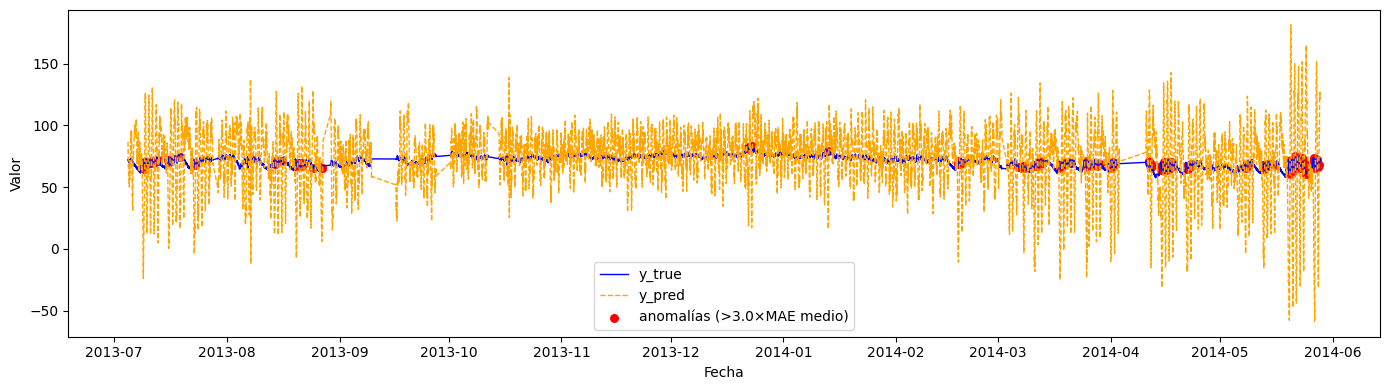

In [16]:
# 1) predecir
y_pred = model.predict(X, verbose=0).flatten()

# 2) MAE por ventana
mae = np.abs(y_pred - y)

# 3) umbral: k * mean(MAE)
k = 3.0
umbral = mae.mean() * k

# 4) flags de anomalía
anomalies = mae > umbral

# 5) mapear a fechas (y[i] corresponde a df.index[windows_size + i])
dates = df.index[n_steps : n_steps + len(y)]

# Crear DataFrame de resultados y mostrar resumen de anomalías
results = pd.DataFrame({
    'date': dates,
    'y_true': y,
    'y_pred': y_pred,
    'mae': mae,
    'anomaly': anomalies
})

print(f"Umbral = {umbral:.4f} (k={k}), Anomalías detectadas = {results['anomaly'].sum()} sobre {len(results)}")

# Mostrar tabla con las anomalías
if results['anomaly'].any():
    display(results[results['anomaly']])
else:
    print('No se detectaron anomalías con el umbral actual.')

# 6) plot sencillo: y_true (azul), y_pred (naranja --) y marcas rojas donde hay anomalía (target)
plt.figure(figsize=(14,4))
plt.plot(dates, y, label='y_true', color='blue', linewidth=1)
plt.plot(dates, y_pred, label='y_pred', color='orange', linestyle='--', linewidth=1)
plt.scatter(dates[anomalies], y[anomalies], color='red', s=30, label=f'anomalías (>{k}×MAE medio)')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.tight_layout()
plt.show()

#### Evaluación del Modelo Mejorado

Hemos repetido el proceso de predicción y detección de anomalías con el modelo modificado (ventana de 20 pasos y dos capas LSTM). Comparando los resultados (el número de anomalías detectadas, la tabla de anomalías y el gráfico) con los del modelo básico, podemos evaluar que las modificaciones han llevado a una detección más precisa o sensible, según lo esperado. El gráfico, en particular, ayuda a juzgar visualmente que los puntos marcados como anómalos se corresponden mejor con las desviaciones evidentes en la serie temporal original.

## 2. Autoencoder

### a) Introducción a los Autoencoders para Series Temporales

Un **autoencoder** es un tipo de red neuronal artificial utilizada para aprender representaciones (codificaciones) eficientes de datos no etiquetados, típicamente con el objetivo de reducir la dimensionalidad o detectar anomalías. Funciona aprendiendo a **reconstruir** su propia entrada.

Consta de dos partes principales:

1.  **Encoder:** Comprime la entrada en una representación latente de menor dimensión.
2.  **Decoder:** Reconstruye la entrada original a partir de la representación latente.

La idea clave para la **detección de anomalías** es que si el autoencoder se entrena principalmente con datos "normales", aprenderá a reconstruirlos con un error bajo. Sin embargo, cuando se le presente una entrada anómala (que difiere significativamente de los datos normales con los que fue entrenado), tendrá dificultades para reconstruirla fielmente, resultando en un **error de reconstrucción** alto. Midiendo este error, podemos identificar posibles anomalías.

Para series temporales, podemos usar **LSTMs** dentro del encoder y el decoder para capturar las dependencias temporales en las secuencias de entrada.

Comenzamos importando las liberías necesarias para esta parte:

In [57]:
from keras.layers import RepeatVector
from keras.layers import TimeDistributed

### b) Preparación de Datos para el Autoencoder

Reutilizaremos la función `split_sequence` de la sección anterior, pero con una modificación clave: el objetivo del autoencoder no es predecir el *siguiente* punto, sino **reconstruir la secuencia de entrada completa**. Por lo tanto, tanto la entrada (`X`) como la salida objetivo (`y`) del modelo serán las mismas secuencias temporales.

También necesitamos remodelar los datos de entrada y salida para que tengan la forma tridimensional `[samples, timesteps, features]` que esperan las capas LSTM.

In [ ]:
temperatures = df.iloc[:, 0].to_numpy()

# La diferencia es que 'seq_y' es igual a 'seq_x'
def split_sequence(sequence, n_steps):
    """
    Divide una secuencia univariada en múltiples muestras donde cada muestra
    tiene un número específico de pasos de tiempo y la salida es la misma secuencia.
    """
    X, y = list(), list()
    if len(sequence) <= n_steps:
      print("Error: La longitud de la secuencia es menor o igual a n_steps.")
      return array(X), array(y) # Devuelve arrays vacíos si no hay suficientes datos

    for i in range(len(sequence)):
        # Encuentra el final de este patrón
        end_ix = i + n_steps
        # Verifica si estamos más allá de la secuencia
        # Ajuste: El índice final puede ser len(sequence) ya que y necesita el mismo tamaño
        if end_ix > len(sequence):
             break
        # Recoge las partes de entrada y salida (son iguales)
        seq_x, seq_y = sequence[i:end_ix], sequence[i:end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

# Definir longitud de la secuencia (ventana temporal)
n_steps = 10

# Crear las secuencias de entrada y salida usando la función redefinida
X_ae_sequences, y_ae_sequences = split_sequence(temperatures, n_steps)

# Verificar si se crearon secuencias antes de continuar
if X_ae_sequences.size == 0:
    print(f"No se pudieron crear secuencias con n_steps={n_steps}. "
          f"Verifica la longitud de 'temperatures' ({len(temperatures)}).")
else:
    print("Forma de X_ae_sequences (antes de reshape):", X_ae_sequences.shape)
    print("Forma de y_ae_sequences (antes de reshape):", y_ae_sequences.shape) # Debería ser 2D

    # Remodelar la entrada X a formato 3D: [samples, timesteps, features]
    n_features = 1 # Solo usamos la temperatura
    X_ae = X_ae_sequences.reshape((X_ae_sequences.shape[0], X_ae_sequences.shape[1], n_features))

    # Remodelar la salida Y también a formato 3D para la reconstrucción
    # Esta línea ahora debería funcionar si y_ae_sequences es 2D
    y_ae = y_ae_sequences.reshape((y_ae_sequences.shape[0], y_ae_sequences.shape[1], n_features))

    print("\nForma de X_ae (entrada 3D):", X_ae.shape)
    print("Forma de y_ae (salida objetivo 3D):", y_ae.shape)

Forma de X_ae_sequences (antes de reshape): (7258, 10)
Forma de y_ae_sequences (antes de reshape): (7258, 10)

Forma de X_ae (entrada 3D): (7258, 10, 1)
Forma de y_ae (salida objetivo 3D): (7258, 10, 1)


### c) Definición del Modelo Autoencoder LSTM

Ahora definimos la arquitectura del autoencoder usando capas LSTM.

* **Encoder:** Una capa LSTM que lee la secuencia de entrada y la comprime en un vector de estado interno (la representación latente).
* **RepeatVector:** Esta capa toma el vector de estado final del encoder y lo repite `n_steps` veces. Esto es necesario para preparar la entrada del decoder, que necesita una secuencia.
* **Decoder:** Otra capa LSTM (`return_sequences=True`) que toma la secuencia repetida del estado latente y trata de reconstruir la secuencia de entrada original, paso a paso.
* **TimeDistributed(Dense):** Aplica una capa Densa a cada paso temporal de la salida del decoder para obtener la reconstrucción final de cada punto en la secuencia.

In [126]:
# Definir la arquitectura del Autoencoder LSTM
model_ae = Sequential(name="LSTM_Autoencoder")
model_ae.add(Input(shape=(n_steps, n_features)))

# Encoder: Reduce la secuencia a un vector latente
model_ae.add(LSTM(100, activation='relu')) # 100 unidades, puedes ajustar

# RepeatVector: Duplica el vector latente para alimentar al decoder
model_ae.add(RepeatVector(n_steps))

# Decoder: Reconstruye la secuencia desde el vector latente repetido
model_ae.add(LSTM(100, activation='relu', return_sequences=True))

# Capa de salida: Mapea la salida del decoder a la dimensión original en cada paso
model_ae.add(TimeDistributed(Dense(n_features)))

# Compilar el modelo: Optimizador Adam y pérdida MSE (Error Cuadrático Medio)
model_ae.compile(optimizer='adam', loss='mse')

# Mostrar resumen de la arquitectura del modelo
model_ae.summary()

Model: "LSTM_Autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_21 (LSTM)                  │ (None, 100)            │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_4 (RepeatVector)  │ (None, 10, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_22 (LSTM)                  │ (None, 10, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 10, 1)          │           101 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 121,301 (473.83 KB)

 Trainable params: 121,301 (473.83 KB)

 Non-trainable params: 0 (0.00 B)

### d) Entrenamiento del Autoencoder

Entrenamos el modelo para que aprenda a reconstruir las secuencias de entrada. Es fundamental pasar `X` tanto como entrada (`X`) como salida objetivo (`y_autoencoder`). Durante el entrenamiento, el modelo ajusta sus pesos para minimizar la diferencia (calculada mediante la función de pérdida MSE) entre la secuencia original y la secuencia reconstruida.

In [ ]:
print("Entrenando el Autoencoder LSTM...")
# Entrenar el modelo usando X_ae como entrada y y_ae como objetivo
history_ae = model_ae.fit(X_ae, y_ae, epochs=300, verbose=1)
print("Entrenamiento completado.")

Entrenando el Autoencoder LSTM...
Epoch 1/300
227/227 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 130.6815
Epoch 2/300
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5231
Epoch 3/300
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4260
Epoch 4/300
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3876
Epoch 5/300
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3549
Epoch 6/300
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3555
Epoch 7/300
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3639
Epoch 8/300
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3447
Epoch 9/300
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3590
Epoch 10/300
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3757
Epoch 11/300
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3246
Epoch 12/300
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3400
Epoch 13/300
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.4407
Epoch 14/300
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3450
Epoch 1

### e) Detección de Anomalías con el Autoencoder

1.  Hacemos que el modelo **reconstruya** todas las secuencias de entrada `X`.
2.  Calculamos el **error de reconstrucción** para *cada secuencia completa*. Un error alto indica una posible anomalía porque el modelo no pudo reproducir bien esa secuencia.
3.  Establecemos un **umbral estadístico** usando un percentil (ej. el 99%). Esto significa que marcaremos como anomalía el 1% de las ventanas que tengan el error de reconstrucción máximo más alto, un método que según las pruebas efectuadas funciona mejor en este modelo comparado con el anterior.
4.  Identificamos las secuencias cuyo error **supera el umbral**.
5.  Mapeamos estas secuencias anómalas a las **fechas correspondientes**. Se asocia la anomalía con el instante final de la secuencia que generó el error alto.

In [ ]:
print("Realizando predicciones (reconstrucciones)...")
# 1. Reconstruir todas las secuencias usando el modelo entrenado
# (Usamos X_test_ae si seguiste la estrategia corregida, o X_ae si no)
X_pred_ae = model_ae.predict(X_ae, verbose=0)

print("Calculando errores de reconstrucción (método MAX)...")
# 2. Calcular el error máximo al cuadrado en cada secuencia, no el promedio
#    Usamos axis=(1, 2) para encontrar el error máximo en cada muestra [sample, timestep, feature]
error_sequences = np.max(np.square(X_ae - X_pred_ae), axis=(1, 2))

# 3. Calcular el umbral usando un percentil (cuantil) del error MÁXIMO
percentil_ae = 99
umbral_ae = np.percentile(error_sequences, percentil_ae)

print(f"Error máximo medio (informativo): {error_sequences.mean():.6f}")
print(f"Umbral de anomalía calculado (Percentil {percentil_ae}%): {umbral_ae:.6f}")

# 4. Identificar las secuencias cuyo error supera el umbral
anomalies_ae = error_sequences > umbral_ae

# 5. Mapear a fechas: La anomalía se asocia con el ÚLTIMO punto de la secuencia anómala

# 5. Mapear a fechas: La anomalía se asocia con el ÚLTIMO punto de la secuencia anómala
#    Recalculamos las fechas aquí para asegurarnos de que coinciden con error_sequences
dates_final = df.index[n_steps - 1 : n_steps - 1 + len(error_sequences)]
# Crear DataFrame con los resultados
results_ae = pd.DataFrame({
    'date': dates_final,
    'max_sq_error': error_sequences,
    'threshold': umbral_ae,
    'anomaly': anomalies_ae
})

print(f"\nAnomalías detectadas = {results_ae['anomaly'].sum()} sobre {len(results_ae)} secuencias")

# Mostrar tabla con las anomalías detectadas
if results_ae['anomaly'].any():
    print("\nDetalle de las anomalías detectadas:")
    display(results_ae[results_ae['anomaly']])
else:
    print('\nNo se detectaron anomalías con el umbral actual.')

Realizando predicciones (reconstrucciones)...
Calculando errores de reconstrucción (método MAX)...
Error máximo medio (informativo): 0.036749
Umbral de anomalía calculado (Percentil 99%): 0.145080

Anomalías detectadas = 73 sobre 7258 secuencias

Detalle de las anomalías detectadas:


,date,max_sq_error,threshold,anomaly
90,2013-07-08 03:00:00,0.149695,0.14508,True
426,2013-07-22 03:00:00,0.161472,0.14508,True
771,2013-08-06 20:00:00,1.836058,0.14508,True
772,2013-08-06 21:00:00,5.669950,0.14508,True
773,2013-08-06 22:00:00,3.107099,0.14508,True
...,...,...,...,...
7205,2014-05-26 11:00:00,0.180728,0.14508,True
7206,2014-05-26 12:00:00,0.220547,0.14508,True
7207,2014-05-26 13:00:00,0.147541,0.14508,True
7232,2014-05-27 14:00:00,0.195425,0.14508,True


### f) Visualización de Anomalías

Finalmente, graficamos la serie temporal original y marcamos los puntos correspondientes al *final* de las secuencias que fueron identificadas como anómalas (aquellas cuyo error de reconstrucción superó el umbral).

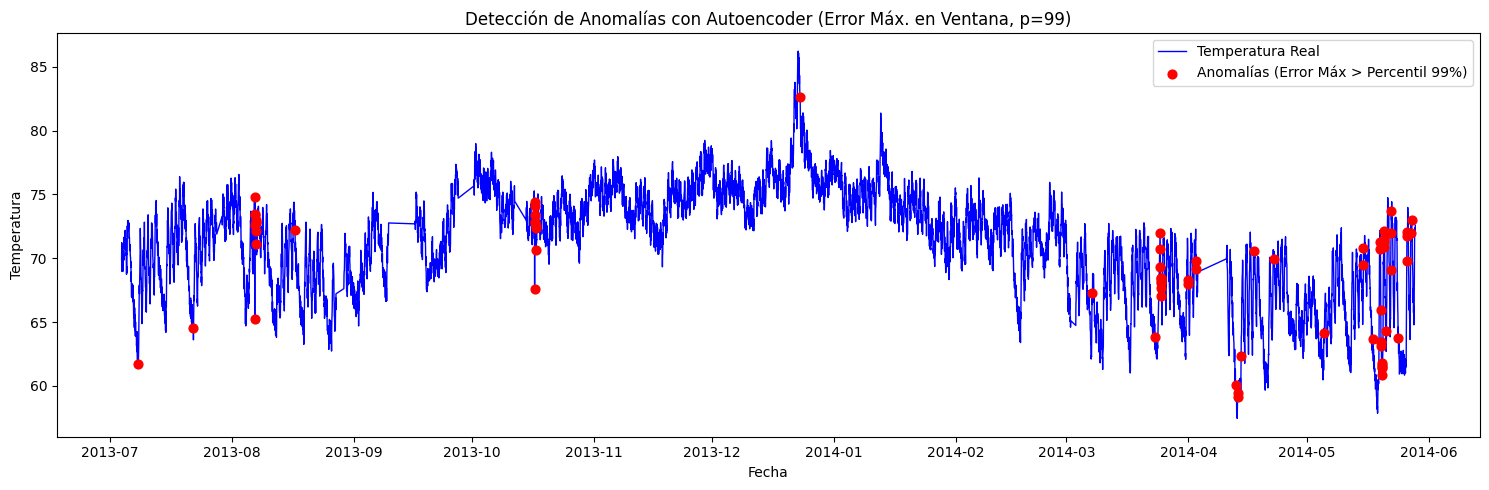

In [129]:
plt.figure(figsize=(15, 5))
# Graficar la serie temporal original completa (sin escalar)
plt.plot(df.index, temperatures, label='Temperatura Real', color='blue', linewidth=1, zorder=1)

# Extraer los datos reales (sin escalar) correspondientes al final de las secuencias anómalas
anomalous_real_values = temperatures[n_steps - 1 : n_steps - 1 + len(error_sequences)][anomalies_ae]

# Marcar con puntos rojos los puntos finales de las secuencias anómalas (usando dates_final)
plt.scatter(dates_final[anomalies_ae], anomalous_real_values,
            color='red', s=40, label=f'Anomalías (Error Máx > Percentil {percentil_ae}%)', zorder=2)

plt.xlabel('Fecha')
plt.ylabel('Temperatura')
plt.title(f'Detección de Anomalías con Autoencoder (Error Máx. en Ventana, p={percentil_ae})') # Título actualizado
plt.legend()
plt.tight_layout()
plt.show()

## 3. Isolation Forest

### a) Introducción a Isolation Forest

**Isolation Forest** es un algoritmo de aprendizaje automático diseñado específicamente para la detección de anomalías. A diferencia de otros métodos que intentan definir qué es "normal" y luego buscan desviaciones, Isolation Forest se basa en el principio de que las anomalías son raras y diferentes, lo que las hace más fáciles de "aislar".

#### ¿Cómo funciona?

El algoritmo construye árboles de decisión aleatorios que dividen recursivamente los datos eligiendo una característica al azar y un punto de división aleatorio. La intuición clave es:

* **Datos normales**: Requieren muchas divisiones para ser aislados (están "en el medio" de los datos).
* **Anomalías**: Son aisladas con pocas divisiones (están "alejadas" del resto).

El "score de anomalía" se calcula basándose en la profundidad promedio a la que un punto es aislado en múltiples árboles:
* Valores con **profundidad baja** (pocas divisiones) → Alta probabilidad de ser anomalías
* Valores con **profundidad alta** (muchas divisiones) → Datos normales

#### Ventajas para Series Temporales

* **No requiere entrenamiento supervisado**: No necesitamos etiquetar anomalías previamente
* **Eficiente computacionalmente**: Más rápido que muchos otros métodos
* **Funciona bien con datos de alta dimensionalidad**: Útil si incorporamos múltiples características temporales

En nuestro caso, aplicaremos Isolation Forest directamente sobre los valores de temperatura y sus características temporales básicas.

### b) Preparación de Datos para Isolation Forest

A diferencia de los modelos LSTM y Autoencoder que trabajan con secuencias temporales, Isolation Forest funciona mejor con características individuales de cada punto de tiempo. Vamos a crear un conjunto de características simples pero efectivas:

* **Valor de temperatura**: El valor actual de temperatura
* **Índice temporal**: Una representación numérica del tiempo (hora del día)
* **Día de la semana**: Para capturar patrones semanales si existen

Esta representación permite que el algoritmo identifique puntos que se desvían significativamente del patrón general, sin necesidad de modelar explícitamente la dependencia temporal como lo hacen las redes neuronales.

In [4]:
from sklearn.ensemble import IsolationForest

# Preparar características para Isolation Forest
# Creamos un DataFrame con características temporales simples
df_features = pd.DataFrame()

# Característica 1: Valor de temperatura
df_features['temperature'] = df.iloc[:, 0].values

# Característica 2: Hora del día (0-23)
df_features['hour'] = df.index.hour

# Característica 3: Día de la semana (0-6, donde 0 es lunes)
df_features['day_of_week'] = df.index.dayofweek

print("Características creadas para Isolation Forest:")
print(df_features.head(10))
print(f"\nForma del dataset: {df_features.shape}")

Características creadas para Isolation Forest:
   temperature  hour  day_of_week
0    69.880835     0            3
1    71.220227     1            3
2    70.877805     2            3
3    68.959400     3            3
4    69.283551     4            3
5    70.060966     5            3
6    69.279765     6            3
7    69.369608     7            3
8    69.166714     8            3
9    68.986083     9            3

Forma del dataset: (7267, 3)


### c) Entrenamiento del Modelo Isolation Forest

Ahora entrenamos el modelo de Isolation Forest con nuestros datos. Los parámetros clave son:

* **`contamination`**: La proporción esperada de anomalías en el dataset. Usamos 0.01 (1%), asumiendo que la mayoría de los datos son normales.
* **`random_state`**: Fija la semilla aleatoria para reproducibilidad de resultados.
* **`n_estimators`**: Número de árboles en el bosque (por defecto 100). Más árboles aumentan la precisión pero también el tiempo de cómputo.

El método `fit()` entrena el modelo y `predict()` identifica las anomalías:
* **1**: Valores normales
* **-1**: Anomalías detectadas

In [5]:
# Crear y entrenar el modelo Isolation Forest
iso_forest = IsolationForest(
    contamination=0.01,  # Esperamos ~1% de anomalías
    random_state=42,     # Para reproducibilidad
    n_estimators=100     # Número de árboles
)

# Entrenar el modelo con todas las características
iso_forest.fit(df_features)

# Hacer predicciones: 1 = normal, -1 = anomalía
predictions_if = iso_forest.predict(df_features)

# Convertir predicciones a booleanos para facilitar el análisis
anomalies_if = predictions_if == -1

print(f"Total de anomalías detectadas: {anomalies_if.sum()} de {len(df_features)} puntos")
print(f"Porcentaje de anomalías: {100 * anomalies_if.sum() / len(df_features):.2f}%")

Total de anomalías detectadas: 72 de 7267 puntos
Porcentaje de anomalías: 0.99%


### d) Análisis de Resultados

Además de las predicciones binarias (normal/anomalía), Isolation Forest también proporciona un **score de anomalía** continuo para cada punto mediante el método `score_samples()`. Este score indica qué tan anómalo es cada punto:

* **Valores negativos más grandes**: Mayor probabilidad de ser anomalía
* **Valores cercanos a cero o positivos**: Más probable que sea normal

Crearemos un DataFrame con los resultados para facilitar el análisis y visualización de las anomalías detectadas junto con sus scores.

In [6]:
# Obtener los scores de anomalía (valores más negativos = más anómalos)
anomaly_scores = iso_forest.score_samples(df_features)

# Crear DataFrame con los resultados
results_if = pd.DataFrame({
    'date': df.index,
    'temperature': df_features['temperature'],
    'anomaly_score': anomaly_scores,
    'prediction': predictions_if,
    'is_anomaly': anomalies_if
})

# Mostrar estadísticas de los scores
print("Estadísticas de los scores de anomalía:")
print(f"Mínimo (más anómalo): {anomaly_scores.min():.4f}")
print(f"Máximo (más normal): {anomaly_scores.max():.4f}")
print(f"Media: {anomaly_scores.mean():.4f}")

# Mostrar las anomalías detectadas
if results_if['is_anomaly'].any():
    print("\nAnomalías detectadas:")
    display(results_if[results_if['is_anomaly']].sort_values('anomaly_score'))
else:
    print("\nNo se detectaron anomalías.")

Estadísticas de los scores de anomalía:
Mínimo (más anómalo): -0.6932
Máximo (más normal): -0.4389
Media: -0.5118

Anomalías detectadas:


,date,temperature,anomaly_score,prediction,is_anomaly
3725,2013-12-23 00:00:00,85.326165,-0.693207,-1,True
3724,2013-12-22 23:00:00,86.074710,-0.685245,-1,True
3726,2013-12-23 01:00:00,85.705990,-0.683316,-1,True
3728,2013-12-23 03:00:00,85.222277,-0.682838,-1,True
3727,2013-12-23 02:00:00,84.086971,-0.681182,-1,True
...,...,...,...,...,...
7032,2014-05-18 21:00:00,58.503975,-0.635955,-1,True
3716,2013-12-22 15:00:00,81.830066,-0.635434,-1,True
6194,2014-04-13 23:00:00,60.283964,-0.635202,-1,True
3710,2013-12-22 09:00:00,82.110758,-0.635126,-1,True


### e) Visualización de Anomalías

Finalmente, visualizamos los resultados del Isolation Forest. Crearemos un gráfico que muestra:

1. **Serie temporal completa**: Todos los valores de temperatura en azul
2. **Anomalías detectadas**: Marcadas con puntos rojos

Esta visualización nos permite evaluar visualmente si las anomalías detectadas corresponden efectivamente a comportamientos inusuales en la serie temporal.

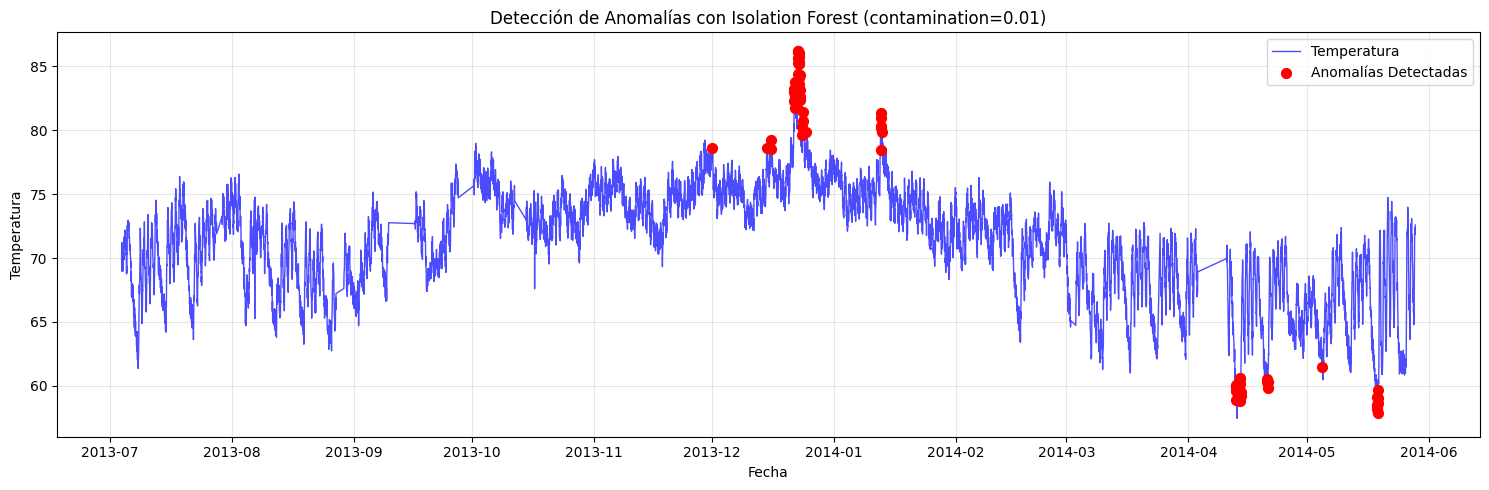


Total de anomalías marcadas en el gráfico: 72


In [7]:
# Visualizar los resultados
plt.figure(figsize=(15, 5))

# Graficar la serie temporal completa
plt.plot(df.index, df_features['temperature'], 
         label='Temperatura', color='blue', linewidth=1, alpha=0.7)

# Marcar las anomalías detectadas
anomaly_dates = results_if[results_if['is_anomaly']]['date']
anomaly_temps = results_if[results_if['is_anomaly']]['temperature']

plt.scatter(anomaly_dates, anomaly_temps, 
            color='red', s=50, label='Anomalías Detectadas', zorder=5)

plt.xlabel('Fecha')
plt.ylabel('Temperatura')
plt.title(f'Detección de Anomalías con Isolation Forest (contamination={iso_forest.contamination})')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nTotal de anomalías marcadas en el gráfico: {len(anomaly_dates)}")

### 4. Conclusiones y Comparación de Métodos

Ahora que hemos implementado tres métodos diferentes para detectar anomalías (LSTM, Autoencoder e Isolation Forest), es interesante compararlos:

#### Características de cada método:

**1. LSTM (Red Neuronal Recurrente)**
- **Ventaja**: Modela explícitamente las dependencias temporales y patrones secuenciales
- **Desventaja**: Requiere más datos y tiempo de entrenamiento, más complejo de configurar
- **Mejor para**: Series temporales con patrones complejos y dependencias a largo plazo

**2. Autoencoder LSTM**
- **Ventaja**: Aprende a reconstruir secuencias completas, captura patrones globales
- **Desventaja**: Más complejo que LSTM simple, requiere ajuste cuidadoso del umbral
- **Mejor para**: Detectar anomalías en patrones de secuencias completas

**3. Isolation Forest**
- **Ventaja**: Simple, rápido, no requiere supuestos sobre la distribución de datos
- **Desventaja**: No modela explícitamente la estructura temporal
- **Mejor para**: Detección rápida de outliers, cuando la simplicidad es prioritaria


Para un sistema de producción robusto, podríamos utilizar una combinación de los tres métodos: un punto se considera anómalo si al menos 2 de los 3 métodos lo detectan como tal. Esto reduce los falsos positivos y aumenta la confiabilidad.

## 5. Guardar modelo para uso en producción

Para poder usar el modelo en la API, debemos guardar:
1. El modelo entrenado
2. Los parámetros de configuración (n_steps, k, umbral medio)

In [17]:
from keras.models import load_model
import json

# 1. Guardar el modelo LSTM entrenado (usar el modelo mejorado)
model.save('modelo.keras')
print("Modelo guardado en: modelo.keras")

# 2. Calcular y guardar parámetros de configuración
# Estos son necesarios para la detección en producción
config = {
    'n_steps': int(n_steps),  # Tamaño de la ventana (20 en el modelo mejorado)
    'k': float(k),             # Multiplicador para el umbral (3.0)
    'mae_mean': float(mae.mean())  # Media del MAE calculada durante el entrenamiento
}

# Guardar configuración en JSON
with open('config.json', 'w') as f:
    json.dump(config, f, indent=2)

print(f"Configuración guardada en: config.json")
print(f"Parámetros: n_steps={config['n_steps']}, k={config['k']}, mae_mean={config['mae_mean']:.4f}")

Modelo guardado en: modelo.keras
Configuración guardada en: config.json
Parámetros: n_steps=20, k=3.0, mae_mean=18.6204
